# Mixup
- Data-dependent regularisation by augmenting data with linear interpolations of observations (inputs and targets)
- Training (batch) loss is quite volatile but doenst show in evaluation the test set
- Softens decision boundary when clusters are easily separatable
- Manifold intrusion messes mixup up
- Observations made based on multiple runs, not just ones shown

In [1]:
import os
import copy
import numpy as np
import seaborn as sns
from collections import defaultdict
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

data_path = os.environ['MS_DATASETS_PATH']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams["figure.figsize"] = (10, 3)

## Utils
Plotting, trainer, evaluation 

In [3]:
def gen_data(c1_mean: (float, float), c2_mean: (float, float), c3_mean: (float, float), len_split: int = 50, plot: bool = False):
    """
    Generate data based on 3 gaussian defined by their mean. Cov is hardcoded.
    :param len_split: number of observations per component in train and test set.
    """
    c1 = torch.FloatTensor(np.random.multivariate_normal(c1_mean, np.eye(2), 2 * len_split))
    c2 = torch.FloatTensor(np.random.multivariate_normal(c2_mean, np.array([[1, -2], [-3, 1]]), 2 * len_split))
    c3 = torch.FloatTensor(np.random.multivariate_normal(c3_mean, np.array([[1, -2], [-2, 1]]), 2 * len_split))

    train_y = torch.LongTensor([0] * len_split + [1] * len_split + [2] * len_split)
    train_X = torch.cat([c1[len_split:], c2[len_split:], c3[len_split:]], dim=0)

    test_y = torch.LongTensor([0] * len_split + [1] * len_split + [2] * len_split)
    test_X = torch.cat([c1[:len_split], c2[:len_split], c3[:len_split]], dim=0)


    if plot:
        f, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
        axarr[0].scatter(train_X[:, 0], train_X[:, 1], c=train_y)
        axarr[0].set_title("Train")

        axarr[1].scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        axarr[1].set_title("Test")
        plt.show()
    return train_X, train_y, test_X, test_y


def plot_perf(bench_logs, mixup_logs):
    """
    Plot benchmark and mixup accuracy and loss for both train and test set
    """
    f, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 5), sharex=False, sharey=False)
    
    axarr[0][0].set_title("Train loss")
    axarr[0][0].plot(bench_logs["train_loss"], label="benchmark")
    axarr[0][0].plot(mixup_logs["train_loss"], label="mixup")
    axarr[0][0].set_ylim([-1, 0])

    axarr[0][1].set_title("Test loss")
    axarr[0][1].plot(bench_logs["test_loss"], label="benchmark")
    axarr[0][1].plot(mixup_logs["test_loss"], label="mixup")
    axarr[0][1].set_ylim([-1, 0])
    
    axarr[1][0].set_title("Train acc")
    axarr[1][0].plot(bench_logs["train_acc"], label="benchmark")
    axarr[1][0].plot(mixup_logs["train_acc"], label="mixup")
    axarr[1][0].set_ylim([0.2, 1])

    axarr[1][1].set_title("Test acc")
    axarr[1][1].plot(bench_logs["test_acc"], label="benchmark")
    axarr[1][1].plot(mixup_logs["test_acc"], label="mixup")
    axarr[1][1].set_ylim([0.2, 1])
    
    plt.legend()
    plt.show()
    
    
def plot_decision_boundaries(bench_model, mixup_model):
    """
    Plot decision boundaries for the benchmark and mixup model
    """
    f, axarr = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
    axarr[0][0].set_title("Benchmark Train")
    _plot_decision_boundary(bench_model, train_X, test_y, ax=axarr[0][0])
    axarr[0][1].set_title("Benchmark Test")
    _plot_decision_boundary(bench_model, test_X, test_y, ax=axarr[0][1])
    axarr[1][0].set_title("Mixup Train")
    _plot_decision_boundary(mixup_model, train_X, test_y, ax=axarr[1][0])
    axarr[1][1].set_title("Mixup Test")
    _plot_decision_boundary(mixup_model, test_X, test_y, ax=axarr[1][1])
    plt.show()

    
def _plot_decision_boundary(model, X=None, y=None, ax=None):
    """
    Plot a single model's decision boundary and the dataset points on top
    """
    num = 100
    d1 = np.linspace(-6, 6, num=num)
    d2 = np.linspace(-6, 6, num=num)
    m1, m2 = np.meshgrid(d1, d2)
    
    mesh = np.vstack([np.ravel(m1), np.ravel(m2)]).T
    preds = model(torch.FloatTensor(mesh)).detach().numpy()

    if ax is None:
        f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    ax.scatter(mesh[:, 0], mesh[:, 1], c=preds)
    if X is not None and y is not None:
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm")
    
    
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''
    @https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
    Returns mixed inputs, pairs of targets, and lambda
    '''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    @https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train(model, use_mixup: bool = False) -> dict:
    """
    Train a model and return a dictionary of logs.
    Uses train and test set as global variables.
    """
    alpha = 0.4
    n_epochs = 10
    batch_size = 10
    
    optimiser = torch.optim.Adam(model.parameters())
    dataset = TensorDataset(train_X, train_y)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    logs = defaultdict(list)
    
    for _ in range(n_epochs):
        
        for batch_X, batch_y in loader:

            if use_mixup:
                X_mixed, y_a, y_b, lam = mixup_data(batch_X, batch_y, alpha=alpha, use_cuda=False)
                out = model(X_mixed)
                loss = mixup_criterion(criterion, out, y_a, y_b, lam)
            else:
                out = model(batch_X)
                loss = criterion(out, batch_y)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            # Log
            logs["train_loss"].append(loss.detach().item())
            logs["train_acc"].append(accuracy(out, batch_y))
            test_loss, test_acc = evaluate(model)
            logs["test_loss"].append(test_loss)
            logs["test_acc"].append(test_acc)
            
    return logs


def accuracy(out, y) -> float:
    """
    Acc between given network outputs and labels
    """
    preds = out.argmax(dim=1)
    acc = (preds == y).float().sum() / len(preds)
    return acc.detach().item()
    

def evaluate(model) -> (float, float):
    """
    evaluation on test set -> loss, acc
    """
    out = model(test_X)
    loss = criterion(out, test_y)
    acc = accuracy(out, test_y)
    return loss.detach().item(), acc

## Experiment 1: Separable Classes

/home/mihai.suteu/work/libs/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  import sys
/home/mihai.suteu/work/libs/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


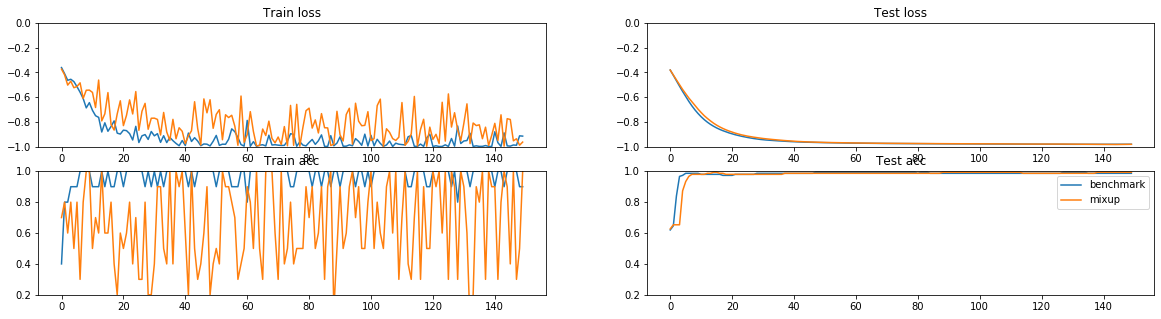

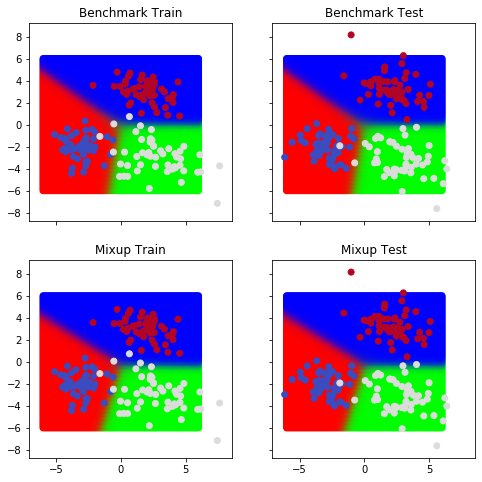

In [8]:
train_X, train_y, test_X, test_y = gen_data((-3, -2), (3, -3), (2, 3))
    

model = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 3), nn.Softmax())
criterion = nn.NLLLoss()

bench_model = copy.deepcopy(model)
bench_logs = train(bench_model, use_mixup=False)

mixup_model = copy.deepcopy(model)
mixup_logs = train(mixup_model, use_mixup=True)


plot_perf(bench_logs, mixup_logs)
plot_decision_boundaries(bench_model, mixup_model)

# Experiment 2: Manifold Intrusion
- An existing class lies within the convex combination of other classes
- Mixup fails to correctly learn the boundaries

/home/mihai.suteu/work/libs/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  import sys
/home/mihai.suteu/work/libs/miniconda3/envs/dev/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


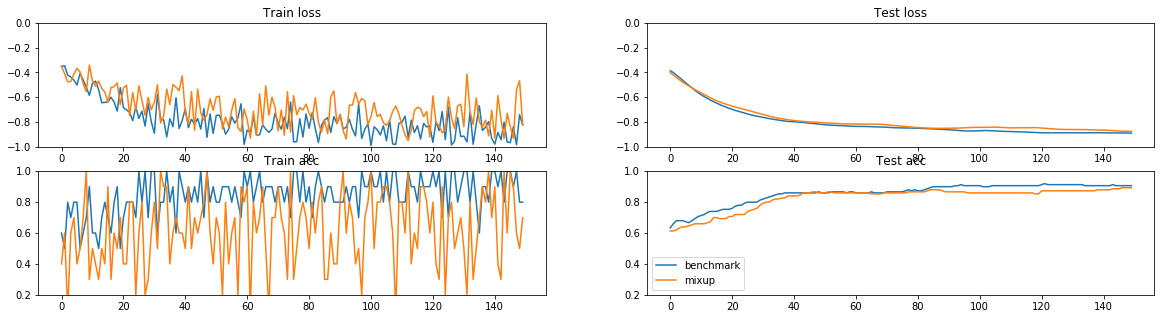

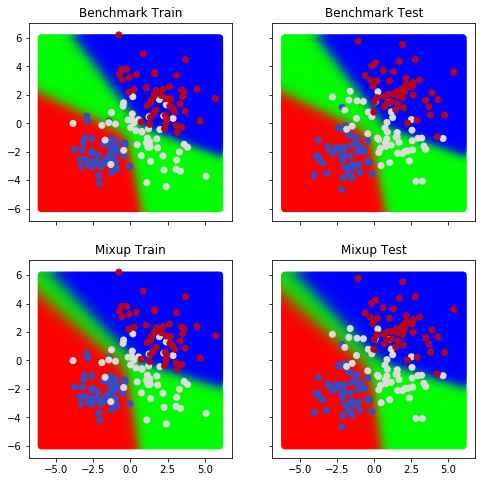

In [7]:
train_X, train_y, test_X, test_y = gen_data((-2, -2), (1, -1), (2, 2))
    

model = nn.Sequential(nn.Linear(2, 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 3), nn.Softmax())
criterion = nn.NLLLoss()

bench_model = copy.deepcopy(model)
bench_logs = train(bench_model, use_mixup=False)

mixup_model = copy.deepcopy(model)
mixup_logs = train(mixup_model, use_mixup=True)


plot_perf(bench_logs, mixup_logs)
plot_decision_boundaries(bench_model, mixup_model)